In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from My_3DResNet_Model import ResNet3D

In [2]:
# Dataset for 3D classification from .nii.gz files
class MRIDataset(Dataset):
    def __init__(self, image_paths, labels_df, label_column="facial_features_present", transform=None):
        self.image_paths = image_paths
        self.labels_df = labels_df
        self.label_column = label_column
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = nib.load(img_path).get_fdata().astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)  # normalize
        img = np.expand_dims(img, axis=0)  # [C, D, H, W]

        filename = os.path.basename(img_path).strip().lower()
        if filename not in self.labels_df.index:
            raise KeyError(f"Filename '{filename}' not found in labels DataFrame index. Sample index: {self.labels_df.index[:5].tolist()}")
        label_str = self.labels_df.loc[filename][self.label_column]
        label = 1.0 if str(label_str).strip().lower() in ['yes', '1', 'true'] else 0.0

        return torch.tensor(img), torch.tensor(label, dtype=torch.float32)


In [3]:
# Paths and file loading
image_dir = "../dataset/files"
label_csv = "../labels.csv"
labels_df = pd.read_csv(label_csv)

# Normalize extensions and ensure matching index format
labels_df.iloc[:, 0] = labels_df.iloc[:, 0].astype(str).apply(lambda x: x.strip().lower().removesuffix('.nii').removesuffix('.gz') + '.nii.gz')
labels_df.set_index(labels_df.columns[0], inplace=True)

image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".nii.gz")])

# Dataset and DataLoader with validation and test split
from sklearn.model_selection import train_test_split

train_val_files, test_files = train_test_split(image_files, test_size=0.1, random_state=42)

# For label classifier
label_column = "Brain-Feature-Loss" # "Recognizable-Facial-Feature", "Brain-Feature-Loss"

test_dataset = MRIDataset(test_files, labels_df, label_column=label_column)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [4]:
def run_gradcam(model, sample_img, target_layer):
    import torch.nn.functional as F
    from scipy.ndimage import zoom
    import numpy as np

    input_tensor = sample_img.unsqueeze(0).cuda().requires_grad_(True)

    class FeatureExtractor:
        def __init__(self, model, target_layer):
            self.model = model
            self.target_layer = target_layer
            self.gradients = None
            self.activations = None
            self.hook()

        def hook(self):
            def forward_hook(module, input, output):
                self.activations = output.detach()
            def backward_hook(module, grad_input, grad_output):
                self.gradients = grad_output[0].detach()
            self.target_layer.register_forward_hook(forward_hook)
            self.target_layer.register_backward_hook(backward_hook)

    # Register hooks and run forward/backward pass
    target = FeatureExtractor(model, target_layer)
    output = model(input_tensor)
    model.zero_grad()
    output.backward()

    # Compute Grad-CAM
    weights = target.gradients.mean(dim=(2, 3, 4), keepdim=True)
    cam = F.relu((weights * target.activations).sum(1)).squeeze().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    # Resize CAM to match input shape
    original_shape = sample_img.squeeze().cpu().numpy().shape
    cam_resized = zoom(cam, np.array(original_shape) / np.array(cam.shape), order=1)

    return cam_resized

def plot_multiview_overlay(original_img, cam, output_file):
    axial = min(cam.shape[0] - 1, original_img.shape[0] // 2)
    coronal = min(cam.shape[1] - 1, original_img.shape[1] // 2)
    sagittal = min(cam.shape[2] - 1, original_img.shape[2] // 2)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(original_img[:, axial, :], cmap='gray')
    axs[0].imshow(cam[axial], cmap='hot', alpha=0.5)
    axs[0].set_title("Axial")

    axs[1].imshow(original_img[coronal], cmap='gray')
    axs[1].imshow(cam[:, coronal, :], cmap='hot', alpha=0.5)
    axs[1].set_title("Coronal")

    axs[2].imshow(original_img[:, :, sagittal], cmap='gray')
    axs[2].imshow(cam[:, :, sagittal], cmap='hot', alpha=0.5)
    axs[2].set_title("Sagittal")

    plt.suptitle(output_file)
    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()

C:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


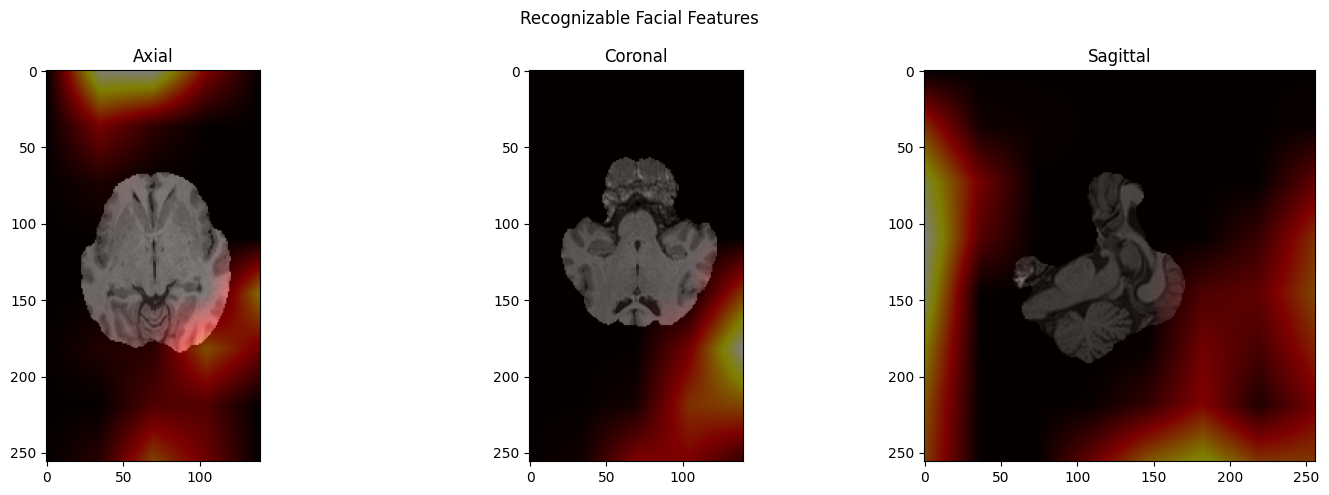

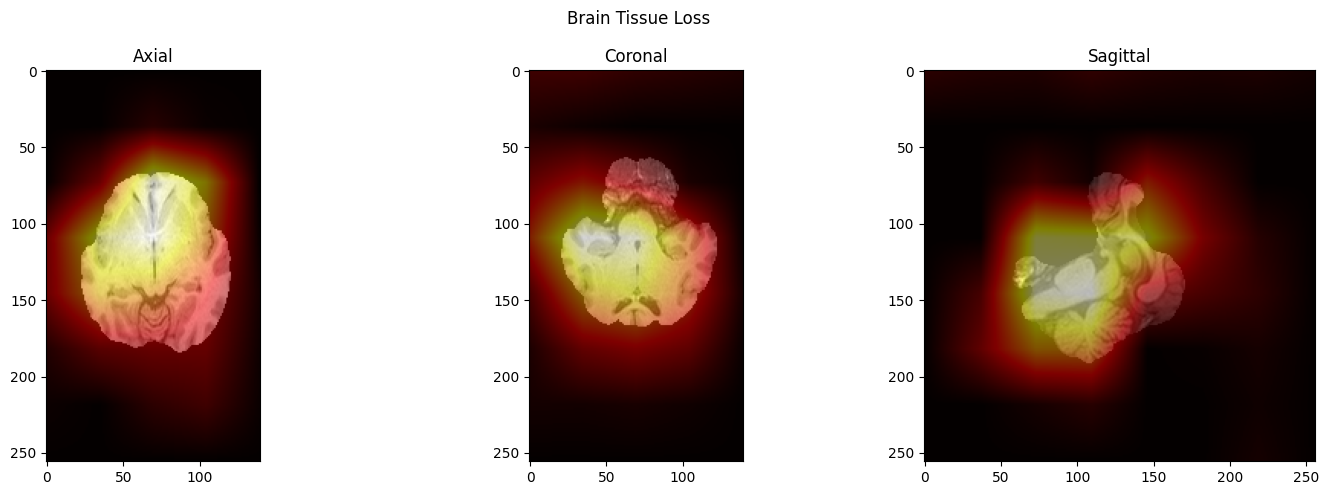

In [5]:
# Facial feature detection model
model_face = ResNet3D()
model_face.load_state_dict(torch.load("resnet3d_face_features_model.pt"))
model_face.eval()

# Brain tissue loss detection model
model_tissue = ResNet3D()
model_tissue.load_state_dict(torch.load("resnet3d_brain_tissue_model.pt"))
model_tissue.eval()

sample_img, _ = test_dataset[33] # 4, 8, 33-aggressive, 37, 41-nonaggressive
    # 18 seems good for what im trying to see
    # 35 is nice - show that its looking in the jaw area for bones
original = sample_img.squeeze().cpu().numpy()

# Grad-CAM for facial feature model
cam_face = run_gradcam(model_face.cuda(), sample_img, model_face.layer4[-1].conv2)
plot_multiview_overlay(original, cam_face, "Recognizable Facial Features")

# Grad-CAM for tissue loss model
cam_tissue = run_gradcam(model_tissue.cuda(), sample_img, model_tissue.layer4[-1].conv2)
plot_multiview_overlay(original, cam_tissue, "Brain Tissue Loss")

######################################
Creating a visualization for the model
######################################


In [20]:
# !pip install torchsummary
from torchsummary import summary
model = ResNet3D()
#model.cuda()

In [21]:
# !pip install tensorboard
# !pip install standard-imghdr
from torch.utils.tensorboard import SummaryWriter

model = ResNet3D().cuda()
dummy_input = torch.randn(1, 1, 64, 128, 128).cuda()

writer = SummaryWriter()
writer.add_graph(model, dummy_input)
writer.close()

# go to http://localhost:6006

In [22]:
from torchviz import make_dot

model = ResNet3D()
input = torch.randn(1, 1, 64, 128, 128)
output = model(input)
make_dot(output, params=dict(model.named_parameters())).render("resnet3d", format="png")


'resnet3d.png'

##################  Histograms  ##################

In [ ]:
import torch
import numpy as np

# FACE FEATURE MODEL
model_face = ResNet3D()
model_face.load_state_dict(torch.load("resnet3d_face_features_model.pt"))
model_face = model_face.cuda()
model_face.eval()

probs_face, labels_face = [], []

with torch.no_grad():
    for images, targets in test_loader:
        images = images.cuda()
        outputs = model_face(images)
        probs_face.append(outputs.cpu().item())
        labels_face.append(targets.item())

# BRAIN TISSUE LOSS MODEL
model_tissue = ResNet3D()
model_tissue.load_state_dict(torch.load("resnet3d_brain_tissue_model.pt"))
model_tissue = model_tissue.cuda()
model_tissue.eval()

probs_tissue, labels_tissue = [], []

with torch.no_grad():
    for images, targets in test_loader:
        images = images.cuda()
        outputs = model_tissue(images)
        probs_tissue.append(outputs.cpu().item())
        labels_tissue.append(targets.item())


In [ ]:
import matplotlib.pyplot as plt

# Convert to NumPy arrays
probs_face = np.array(probs_face)
labels_face = np.array(labels_face)
probs_tissue = np.array(probs_tissue)
labels_tissue = np.array(labels_tissue)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Facial Feature Histogram
axs[0].hist(probs_face[labels_face == 0], bins=20, alpha=0.7, label="Negative (No Face)")
axs[0].hist(probs_face[labels_face == 1], bins=20, alpha=0.7, label="Positive (Face Present)")
axs[0].set_title("Face Feature Model: Predicted Probability Histogram")
axs[0].set_xlabel("Predicted Probability")
axs[0].set_ylabel("Frequency")
axs[0].legend()
axs[0].grid(True)

# Brain Tissue Loss Histogram
axs[1].hist(probs_tissue[labels_tissue == 0], bins=20, alpha=0.7, label="Negative (No Tissue Loss)")
axs[1].hist(probs_tissue[labels_tissue == 1], bins=20, alpha=0.7, label="Positive (Tissue Loss)")
axs[1].set_title("Brain Tissue Loss Model: Predicted Probability Histogram")
axs[1].set_xlabel("Predicted Probability")
axs[1].set_ylabel("Frequency")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()
